In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
files= list()
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        files.append(dirname + '/' + filename)
        print(os.path.join(dirname, filename))
        
print(files)

/kaggle/input/moscow-housing-price-dataset/data.csv
['/kaggle/input/moscow-housing-price-dataset/data.csv']


In [2]:
from sklearnex import patch_sklearn, unpatch_sklearn
patch_sklearn()
#unpatch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
df = pd.read_csv(files[0])
print(df.shape)
df.head()

(22676, 12)


,Price,Apartment type,Metro station,Minutes to metro,Region,Number of rooms,Area,Living area,Kitchen area,Floor,Number of floors,Renovation
0,6300000.0,Secondary,Опалиха,6.0,Moscow region,1.0,30.6,11.1,8.5,25.0,25,Cosmetic
1,9000000.0,Secondary,Павшино,2.0,Moscow region,1.0,49.2,20.0,10.0,6.0,15,European-style renovation
2,11090000.0,Secondary,Мякинино,14.0,Moscow region,1.0,44.7,16.2,13.1,10.0,25,Cosmetic
3,8300000.0,Secondary,Строгино,8.0,Moscow region,1.0,35.1,16.0,11.0,12.0,33,European-style renovation
4,6450000.0,Secondary,Опалиха,6.0,Moscow region,1.0,37.7,15.2,4.0,5.0,5,Without renovation


In [4]:
y = df['Price']
df = df.drop('Price', axis=1)

In [5]:
print('Missed values at all:',df.isna().sum().sum())

Missed values at all: 0


Target - 'Price' columns.

Lets make EDA to other columns

In [6]:
bin_cols = ['Apartment type']
df['Apartment type'].value_counts()

Apartment type
Secondary       13152
New building     9524
Name: count, dtype: int64

We can see that 'Apartment type' column takes only two values, we can easy replace 'Secondary' and 'new building' as 0 and 1

Now lets try to encode 'metro stantion' column.

In [7]:
mean_target_cols = ['Metro station']
df['Metro station'].value_counts()

Metro station
Красногвардейская            2697
Депо                         1646
Братиславская                1157
Котельники                    981
Жулебино                      731
                             ... 
 Каховская                      1
 Вешняки                        1
 Текстильщики                   1
 Марксистская                   1
 Улица Академика Королёва       1
Name: count, Length: 547, dtype: int64

I would like to use the Mean target encoding, just cause the price of housing in Moscow strongly depends on the location

In [8]:
bin_cols.append('Region')
df['Region'].value_counts()

Region
Moscow           16113
Moscow region     6563
Name: count, dtype: int64

Region exactly takes binary values

In [9]:
one_hot_cols = ['Renovation']
one_hot_cols+= bin_cols
df['Renovation'].value_counts()

Renovation
Cosmetic                     12788
European-style renovation     3666
Without renovation            3198
Designer                      3024
Name: count, dtype: int64

Lest encode "Renovation" column by one-hot

Other columns is just numeric values, we will StandartScale it later

In [10]:
num_cols = df.select_dtypes(exclude=['object']).columns.to_list()
num_cols

['Minutes to metro',
 'Number of rooms',
 'Area',
 'Living area',
 'Kitchen area',
 'Floor',
 'Number of floors']

Lets make MeanTargetTransformer for Metro station column

(i lied chatgpt made it)

((i lied twice we made it together (me 77%, him 33%)))

I want to make pipeline now

In [11]:
from sklearn.preprocessing import StandardScaler, Binarizer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.pipeline import Pipeline


col_trans = ColumnTransformer([
    ('scaler', StandardScaler(), num_cols),
    ('onehot', OneHotEncoder(drop='first'), one_hot_cols),
])
model = Pipeline([
    ('trans', col_trans),
    ('model', ElasticNet())
])

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size= 0.11,random_state = 21)
if 'Price' not in df.columns.to_list():
    means = pd.concat([X_train, y_train], axis = 1).groupby('Metro station')['Price'].mean()
df['Metro station'] = df['Metro station'].map(means)

df = pd.concat([X_train, y_train], axis = 1)
print(df.shape[0])
target = 'Price'
Q1 = df[target].quantile(0.25)
Q3 = df[target].quantile(0.75)
IQR = Q3 - Q1

# Определение границ
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df[target] >= lower_bound) & (df[target] <= upper_bound)]
print(df.shape[0])
y = df[target]
df = df.drop(target, axis = 1)

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size= 0.11,random_state = 21)

model.fit(X_train, y_train)

INFO:sklearnex: sklearn.model_selection.train_test_split: fallback to original Scikit-learn
INFO:sklearnex: sklearn.model_selection.train_test_split: running accelerated version on CPU
INFO:sklearnex: sklearn.model_selection.train_test_split: fallback to original Scikit-learn
INFO:sklearnex: sklearn.model_selection.train_test_split: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.ElasticNet.fit: running accelerated version on CPU


20181
17198


Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['Minutes to metro',
                                                   'Number of rooms', 'Area',
                                                   'Living area',
                                                   'Kitchen area', 'Floor',
                                                   'Number of floors']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Renovation',
                                                   'Apartment type',
                                                   'Region'])])),
                ('model', ElasticNet())])

In [12]:
preds = model.predict(X_test)
from sklearn.metrics import mean_squared_error as MSE
print(MSE(y_test, preds) ** 0.5)

INFO:sklearnex: sklearn.linear_model.ElasticNet.predict: running accelerated version on CPU


5892223.693092426


In [13]:
param_grid = {
    'model__alpha': [0.00031622776601683794],  # значения alpha от 0.0001 до 10
    'model__l1_ratio': [0.21]  # значения l1_ratio от 0 до 1
}

In [14]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', verbose=10)
grid.fit(X_train, y_train)

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.ElasticNet.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.ElasticNet.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.ElasticNet.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite:

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START model__alpha=0.00031622776601683794, model__l1_ratio=0.21...
[CV 1/5; 1/1] END model__alpha=0.00031622776601683794, model__l1_ratio=0.21;, score=-22358433778639.453 total time=   0.0s
[CV 2/5; 1/1] START model__alpha=0.00031622776601683794, model__l1_ratio=0.21...
[CV 2/5; 1/1] END model__alpha=0.00031622776601683794, model__l1_ratio=0.21;, score=-21132720512843.598 total time=   0.0s
[CV 3/5; 1/1] START model__alpha=0.00031622776601683794, model__l1_ratio=0.21...


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.ElasticNet.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.ElasticNet.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


[CV 3/5; 1/1] END model__alpha=0.00031622776601683794, model__l1_ratio=0.21;, score=-22258190200736.742 total time=   0.0s
[CV 4/5; 1/1] START model__alpha=0.00031622776601683794, model__l1_ratio=0.21...
[CV 4/5; 1/1] END model__alpha=0.00031622776601683794, model__l1_ratio=0.21;, score=-22109588952401.984 total time=   0.0s
[CV 5/5; 1/1] START model__alpha=0.00031622776601683794, model__l1_ratio=0.21...


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.ElasticNet.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.ElasticNet.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.ElasticNet.fit: running accelerated version on CPU


[CV 5/5; 1/1] END model__alpha=0.00031622776601683794, model__l1_ratio=0.21;, score=-21875071062940.387 total time=   0.0s


GridSearchCV(estimator=Pipeline(steps=[('trans',
                                        ColumnTransformer(transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         ['Minutes '
                                                                          'to '
                                                                          'metro',
                                                                          'Number '
                                                                          'of '
                                                                          'rooms',
                                                                          'Area',
                                                                          'Living '
                                                                          'area',
                                                                          'Kitchen '
                                                                          'area',
                                                                          'Floor',
                                                                          'Number '
                                                                          'of '
                                                                          'floors']),
                                                                        ('onehot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Renovation',
                                                                          'Apartment '
                                                                          'type',
                                                                          'Region'])])),
                                       ('model', ElasticNet())]),
             param_grid={'model__alpha': [0.00031622776601683794],
                         'model__l1_ratio': [0.21]},
             scoring='neg_mean_squared_error', verbose=10)

In [15]:
print((-grid.best_score_)**0.5)
print(grid.best_params_)
print(MSE(y_test, grid.predict(X_test)) ** 0.5)

INFO:sklearnex: sklearn.linear_model.ElasticNet.predict: running accelerated version on CPU


4684741.28437339
{'model__alpha': 0.00031622776601683794, 'model__l1_ratio': 0.21}
4831536.3669095235


Первая версия: рмсе - 49кк

Вторая версия: рмсе - 4.7 кк (удалили выбросы в самом начале)


In [16]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from datetime import datetime as dt

param_grid = [
    {
        'model': [GradientBoostingRegressor()],
        'model__n_estimators': [600], #600 is the best
        'model__learning_rate': [0.2],
        'model__max_depth': [5],
        'model__min_samples_split': [5],
        'model__min_samples_leaf': [2],
        'model__subsample': [1.0]
    }
]
param_grid2 = [
    {
        'model': [RandomForestRegressor()],
        'model__n_estimators': [400], #400
        'model__max_features': ['log2'],
        'model__max_depth': [30],
        'model__min_samples_split': [2, 10],
        'model__min_samples_leaf': [1, 2]
    },
    
]
start = dt.now()
print('start time\t',start)
grid = GridSearchCV(model, param_grid2, scoring='neg_mean_squared_error', verbose=10)
#grid.fit(X_train, y_train)
end = dt.now() - start
print('total time\t', end)

start time	 2024-07-02 15:11:49.515526
total time	 0:00:00.000215


patched sklearn total time: 49 seconds

UNpatched total time: 1 minute 27 seconds 

In [17]:
best_params_gradient = {
    'model': GradientBoostingRegressor(learning_rate=0.2,
                                       max_depth=5,
                                       min_samples_leaf=2,
                                       min_samples_split=5,
                                       n_estimators=600),
}
best_params_random = {
    'model': RandomForestRegressor(max_depth=30, 
                                   max_features='log2', 
                                   n_estimators=400,
                                   min_samples_leaf = 1,
                                   min_samples_split = 2,)
}
best_params_elastic = {
    'model': ElasticNet(alpha = 0.00031622776601683794, l1_ratio = 0.21),
}

best_params_array = [
    best_params_gradient,
    best_params_random,
    best_params_elastic,
]

In [18]:
#print('best params: \t',grid.best_params_)
#model.set_params(**grid.best_params_)
model.set_params(**best_params_random)
start = dt.now()
model.fit(X_train, y_train)
end = dt.now() - start
print('total time\t\t', end)
preds = model.predict(X_test)
print('test val score:\t\t', MSE(y_test, preds) ** 0.5)

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


total time		 0:00:05.202076


INFO:sklearnex: sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU


test val score:		 3317984.213941416


In [19]:
gr = pd.DataFrame({'test' : y_test.values, 'preds': preds})
gr = gr.sort_values(['test'])
gr

,test,preds
413,1150000.0,3.412690e+06
1141,1941650.0,2.028224e+06
407,2390000.0,3.931039e+06
1524,2607300.0,2.662517e+06
558,2607300.0,2.664596e+06
...,...,...
1400,50983800.0,3.070893e+07
1300,51000000.0,4.667119e+07
237,51000000.0,2.872003e+07
327,51000000.0,3.770169e+07


In [20]:
preds = model.predict(df)
gr = pd.DataFrame({'test' : y.values, 'preds': preds})
gr

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


,test,preds
0,3094710.0,3.120024e+06
1,34990000.0,3.514180e+07
2,3285243.0,3.213529e+06
3,10879360.0,1.070616e+07
4,9090240.0,9.025143e+06
...,...,...
17193,5582764.0,5.871382e+06
17194,19500000.0,2.183676e+07
17195,12450000.0,1.257478e+07
17196,9800000.0,1.171393e+07


In [21]:
def get_variable_name(variable, local_vars):
    return [name for name, value in local_vars.items() if value is variable]

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.ensemble.RandomForestRegressor.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


1 is ploted


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.ensemble.RandomForestRegressor.predict: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.ElasticNet.fit: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.ElasticNet.predict: running accelerated version on CPU


2 is ploted
3 is ploted


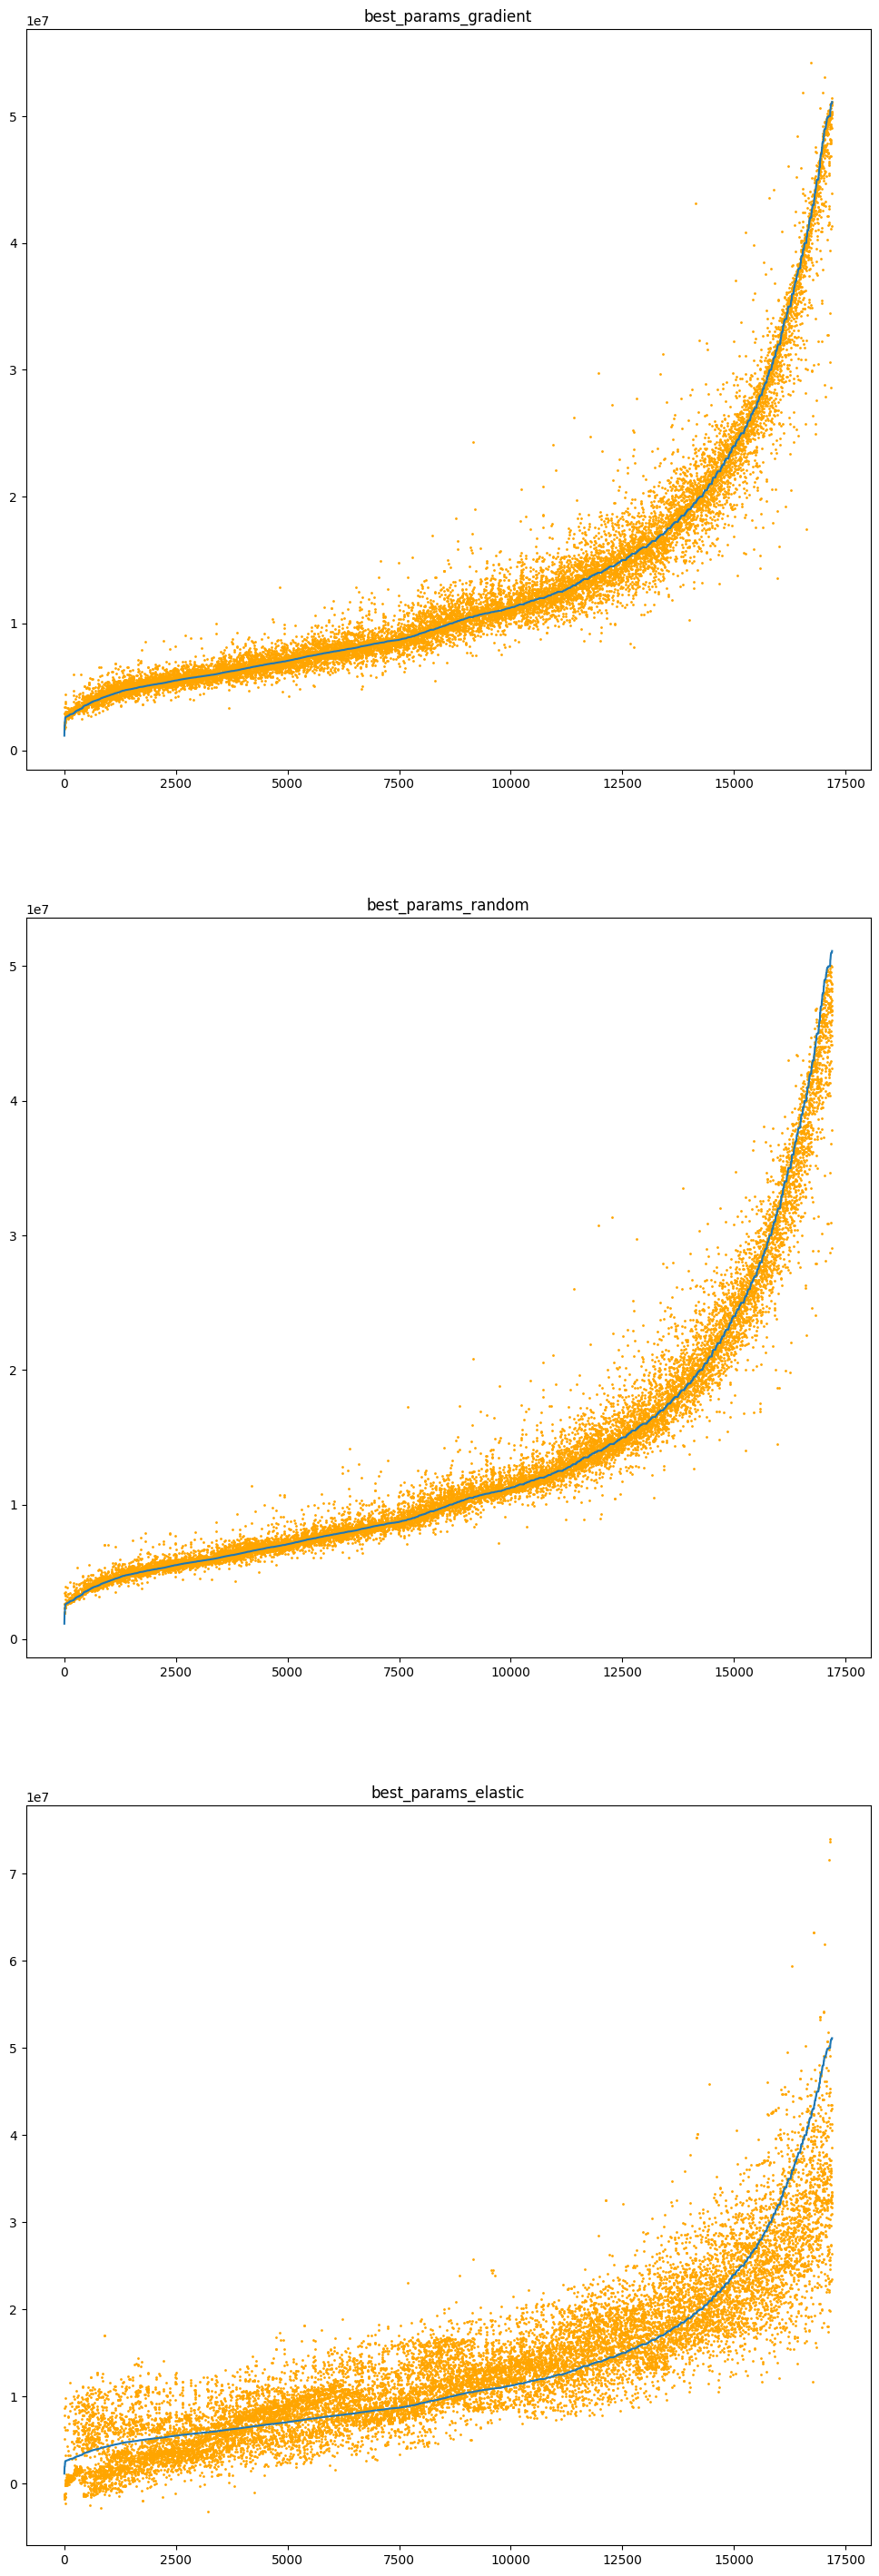

In [22]:
size = 12
fig = plt.figure(figsize=(size, len(best_params_array) * size))

for k, i in enumerate(best_params_array, 1):
    fig.add_subplot(len(best_params_array), 1, k)
    
    model.set_params(**i)
    
    model.fit(X_train, y_train)
    preds = model.predict(df)
    
    gr = pd.DataFrame({'test' : y.values, 'preds': preds})
    gr = gr.sort_values(['test'])
    
    plt.plot(np.arange(0, gr.shape[0]), gr.test.values)
    plt.scatter(np.arange(0, gr.shape[0]), gr.preds.values, c='orange', s = 1)
    plt.title(get_variable_name(i, locals())[0])
    print(f'{k} is ploted')

Best model test validation score:  3 290 488


best gradient boost score:  3 451 674

total 'gradient' unpatched time \ patched : ( 0:00:17.354130 \  0:00:17.259335 )